# Data Processing, Exploratory Data Analysis, and Feature Engineering

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.metrics import root_mean_squared_error, root_mean_squared_log_error, mean_absolute_error

In [ ]:
path = '/content/drive/MyDrive/Product Sales Forecasting/data/'
mod_names = ['holt_winters', 'sarimax', 'lightgbm', 'prophet']

# Get train and test data using 'date' as the index
train = pd.read_csv(f'{path}train.csv', usecols=['date', 'qty'], index_col='date', parse_dates=True)
test = pd.read_csv(f'{path}test.csv', usecols=['date', 'qty'], index_col='date', parse_dates=True)

# Load csv files with forecasts and concatenate into one data frame
forecasts = []
for mod_name in mod_names:
  forecast = pd.read_csv(path + f'forecast_{mod_name}.csv', index_col='date', parse_dates=True)
  forecast.rename(columns={'forecast': mod_name}, inplace=True)
  forecasts.append(forecast)
forecasts = pd.concat(forecasts, axis=1)

# Create ensemble using the average of predictions
forecasts['ensemble'] = forecasts[mod_names].mean(axis=1)

display(forecasts)

,holt_winters,sarimax,lightgbm,prophet,ensemble
date,,,,,
2024-06-03,4.692367,4.580049,5.756714,4.979936,5.002266
2024-06-04,3.919139,4.656036,5.272454,4.457348,4.576244
2024-06-05,4.723150,4.459959,5.570707,4.200311,4.738532
2024-06-06,3.895580,5.317548,4.950160,4.613965,4.694313
2024-06-07,5.193071,6.015394,5.171344,5.538021,5.479458
...,...,...,...,...,...
2025-05-28,2.083071,3.703961,3.575452,2.738017,3.025125
2025-05-29,3.728758,4.080434,3.544780,3.151086,3.626264
2025-05-30,3.549813,5.268040,4.439499,4.069760,4.331778


In [ ]:
# Return RMSE, MAE, RMSLE, and sMAPE scores
def evaluate_preds(y, y_pred, label):
  # Compute sMAPE
  def smape_score(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_pred - y_true)
    mask = denominator != 0 # Avoid division by zero
    smape_val = np.mean(diff[mask] / denominator[mask]) * 100
    return smape_val

  rmse = root_mean_squared_error(y, y_pred)
  mae = mean_absolute_error(y, y_pred)
  rmsle = root_mean_squared_log_error(y, y_pred)
  smape = smape_score(y, y_pred)

  scores = pd.DataFrame({'RMSE': [rmse], 'MAE': [mae], 'RMSLE': [rmsle], 'sMAPE': [smape]})
  scores.index = [label]

  return(scores)

def display_scores(scores):
  display(pd.concat(scores, axis=1).round(4))

# Plot forecast
def plot_forecast(test, forecasts, title, test_color='black'):
  plt.figure(figsize=(16, 6))
  test.plot(label='True', alpha=0.8, color=test_color)
  for col in forecasts:
    forecasts[col].plot(label=col)
  plt.title(title)
  plt.legend()
  plt.show()

In [ ]:
# Naïve Forecast using average of training set target values

train_mean = [train['qty'].mean()]
naive_train_scores = evaluate_preds(train['qty'], train_mean * train.shape[0], 'Naïve Train Scores')
naive_test_scores = evaluate_preds(test['qty'], train_mean * test.shape[0], 'Naïve Test Scores')
display(pd.concat([naive_train_scores, naive_test_scores]).round(4))

,RMSE,MAE,RMSLE,sMAPE
Naïve Train Scores,4.4736,3.4149,0.7127,59.4749
Naïve Test Scores,4.3680,3.3521,0.8260,67.9012


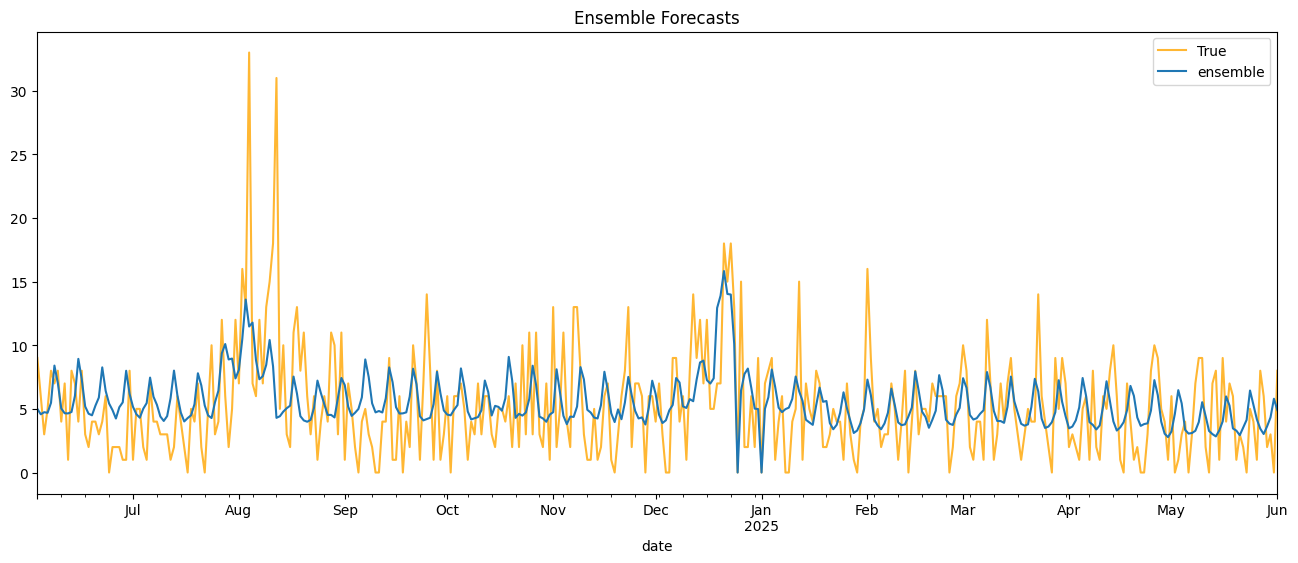

In [ ]:
plot_forecast(test['qty'], forecasts[['ensemble']], 'Ensemble Forecasts', 'orange')

In [ ]:
# RMSE, MAE, and SMAPE scores by cv fold
scores = {col: [] for col in forecasts}
for col in forecasts:
  for i in range(0, 364, 28):
    test_fold = test.iloc[i:i + 28]
    scores_i = evaluate_preds(test_fold['qty'], forecasts.iloc[i:i + 28][col], test_fold.index[0])
    scores[col].append(scores_i)
  scores[col] = pd.concat(scores[col])
  scores[col].index.name = 'Fold'

In [ ]:
# Score means across folds
score_means = []
for col in forecasts:
  score_means.append(scores[col].mean().rename(col))

display_scores(score_means)

,holt_winters,sarimax,lightgbm,prophet,ensemble
RMSE,3.7633,3.7024,3.7016,3.6152,3.5843
MAE,2.9712,2.9481,2.9455,2.8855,2.8705
RMSLE,0.7043,0.7243,0.7198,0.6981,0.7020
sMAPE,65.9368,63.9775,63.6657,64.0489,63.4908


|Metric|Holt-Winters|SARIMAX|LightGBM|Prophet|Ensemble|
|:-----|:----------:|:-----:|:------:|:-----:|:------:|
|RMSE|3.7633|3.7024|3.7016|3.6152|3.5843|
|MAE|2.9712|2.9481|2.9455|2.8855|2.8705|
|RMSLE|0.7043|0.7243|0.7198|0.6981|0.7020|
|SMAPE|65.9368|63.9775|63.6657|64.0489|63.4908|
|Approx. Fit Time|**0.5 sec** (SP=7) + **1.24 sec** (SP=364)|**25.75 sec** (14.04 sec w/o regressors)|**0.04 sec** (0.34 sec w/ 108 features)|**0.38 sec**|X

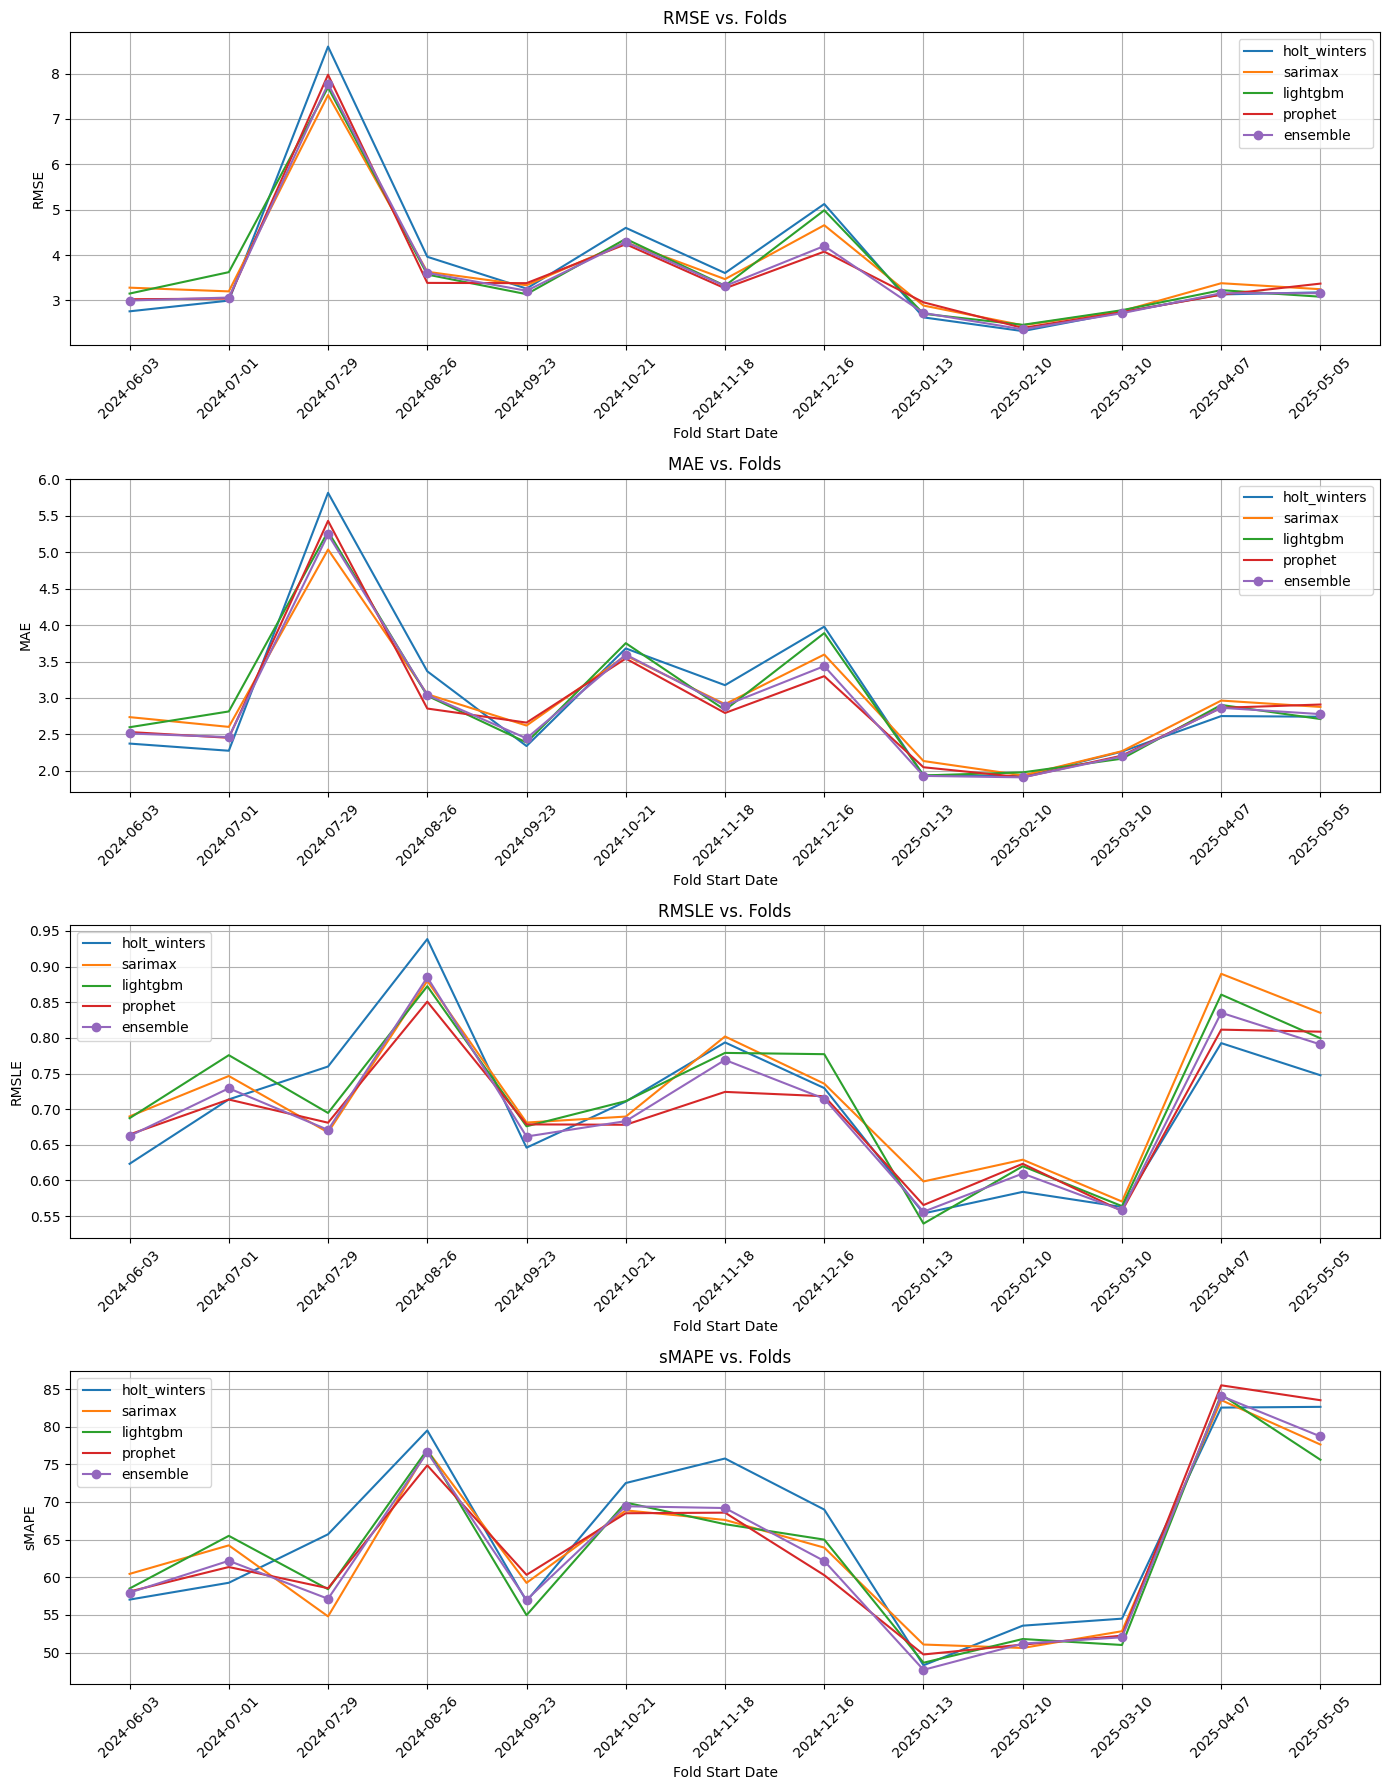

In [ ]:
# Plot scores vs. fold for each metric

metrics = score_means[0].index

plt.figure(figsize=(14, 18))

for i, metric in enumerate(metrics):
  plt.subplot(len(metrics), 1, i + 1)
  marker = None
  for col in scores:
    if col == 'ensemble':
      marker = 'o'
    plt.plot(scores[col][metric], label=col, marker=marker)
  plt.xlabel('Fold Start Date')
  plt.ylabel(metric)
  plt.xticks([x.strftime('%Y-%m-%d') for x in scores[col].index], rotation=45)
  plt.title(f'{metric} vs. Folds')
  plt.grid()
  plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Get sum of counts for each week and evaluate metrics
num_weeks = 1

weekly_sums = test.groupby(np.arange(364) // (num_weeks * 7)).sum().rename(columns={'qty': 'true'})
weekly_sums.index = test.index[::(num_weeks * 7)]
display(weekly_sums.describe().T)

weekly_scores = []
for col in forecasts:
  weekly_sums[col] = forecasts[col].groupby(np.arange(364) // (num_weeks * 7)).sum().values
  weekly_scores.append(evaluate_preds(weekly_sums['true'], weekly_sums[col], col).T)

display_scores(weekly_scores)

,count,mean,std,min,25%,50%,75%,max
true,52.0,36.653846,14.875806,16.0,27.75,33.5,39.0,88.0


,holt_winters,sarimax,lightgbm,prophet,ensemble
RMSE,13.2649,11.5045,11.5859,10.7639,10.7332
MAE,9.1230,9.0210,8.7368,8.1828,8.1507
RMSLE,0.3169,0.3177,0.3039,0.2914,0.2892
sMAPE,24.1058,24.6501,23.4210,22.5500,22.2744


|Metric|Holt-Winters|SARIMAX|LightGBM|Prophet|Ensemble|
|:-----|:----------:|:-----:|:------:|:-----:|:------:|
RMSE|13.2649|11.5045|11.5859|10.7639|10.7332
MAE|9.1230|9.0210|8.7368|8.1828|8.1507
RMSLE|0.3169|0.3177|0.3039|0.2914|0.2892
sMAPE|24.1058|24.6501|23.4210|22.5500|22.2744

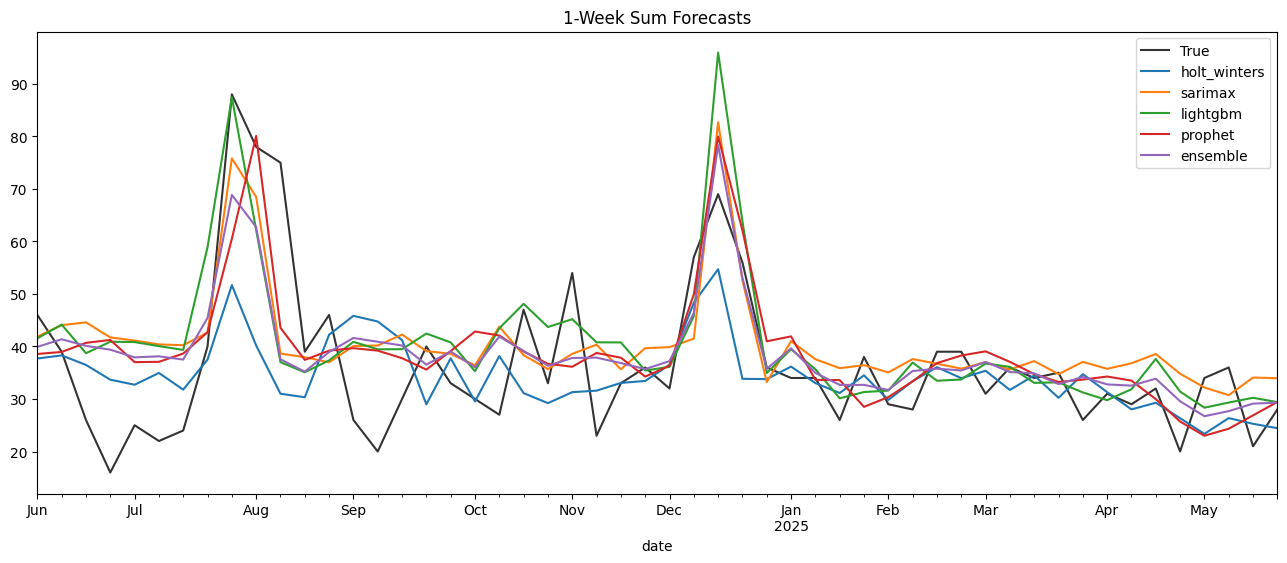

In [ ]:
plot_forecast(weekly_sums['true'],  weekly_sums.drop('true', axis=1), f'{num_weeks}-Week Sum Forecasts')

In [ ]:
# Get sum of counts for each 2-week period and evaluate metrics
num_weeks = 2

weekly_sums = test.groupby(np.arange(364) // (num_weeks * 7)).sum().rename(columns={'qty': 'true'})
weekly_sums.index = test.index[::(num_weeks * 7)]
display(weekly_sums.describe().T)

weekly_scores = []
for col in forecasts:
  weekly_sums[col] = forecasts[col].groupby(np.arange(364) // (num_weeks * 7)).sum().values
  weekly_scores.append(evaluate_preds(weekly_sums['true'], weekly_sums[col], col).T)

display_scores(weekly_scores)

,count,mean,std,min,25%,50%,75%,max
true,26.0,73.307692,26.550735,42.0,60.0,69.5,76.0,166.0


,holt_winters,sarimax,lightgbm,prophet,ensemble
RMSE,22.9800,18.2882,19.0144,16.8006,17.2540
MAE,14.5731,13.8939,14.0706,12.7317,12.2769
RMSLE,0.2668,0.2615,0.2543,0.2375,0.2364
sMAPE,18.5924,19.1434,18.5651,17.4486,16.7887


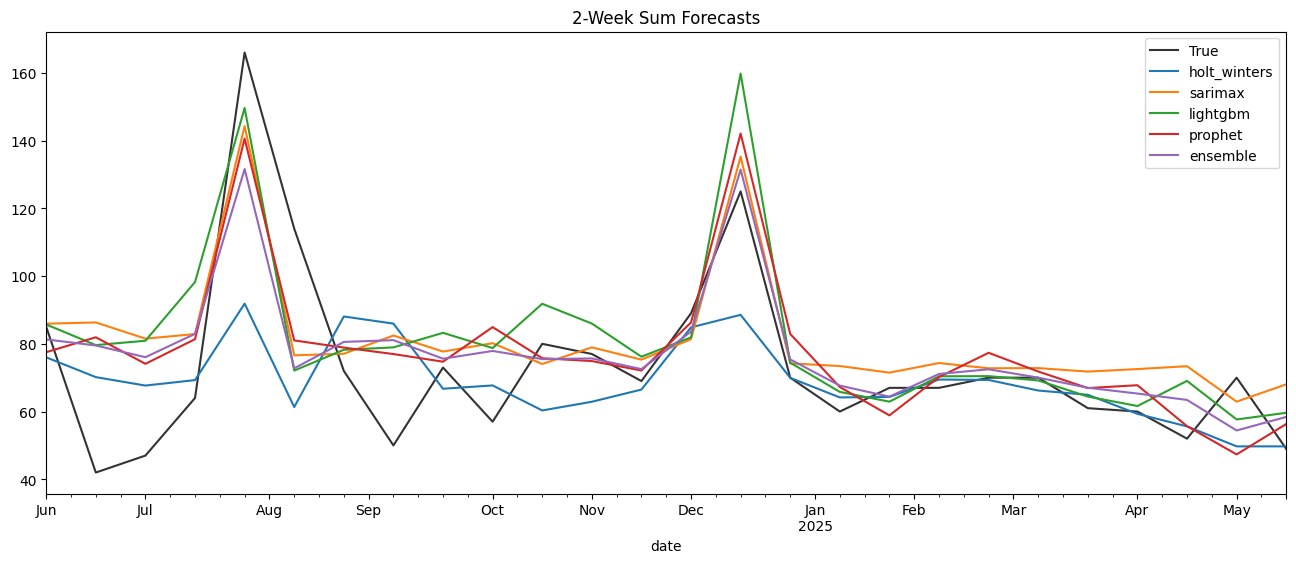

In [ ]:
plot_forecast(weekly_sums['true'],  weekly_sums.drop('true', axis=1), f'{num_weeks}-Week Sum Forecasts')